# Reviewing La ReUnion forecasts against IBTrACS and La ReUnion Best Track Data

This notebook reviews the forecast intensity by lead time using both IBTrACS and Best Track Data to understand how correctly the intensity is forecasted.

In [20]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from pathlib import Path
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

from src.datasources import rsmc, helpers, codab
from src.utils import categorize_cyclone, category_order

In [22]:
# Complete list of storms we are interested in
all_storms = [
    "FAVIO",
    "JOKWE",
    "IZILDA",
    "DANDO",
    "IRINA",
    "HARUNA",
    "DELIWE",
    "GUITO",
    "HELLEN",
    "CHEDZA",
    "DINEO",
    "DESMOND",
    "IDAI",
    "KENNETH",
    "CHALANE",
    "ELOISE",
    "GUAMBE",
    "ANA",
    "GOMBE",
    "JASMINE",
    "FREDDY",
    "FILIPO",
]

<Axes: >

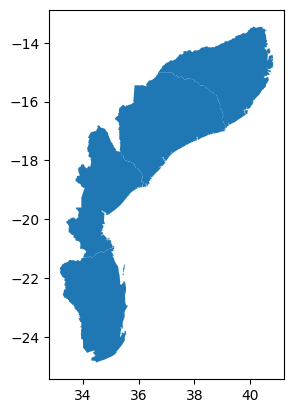

In [23]:
adm = codab.load_codab(aoi_only=True)
adm.plot()

In [24]:
df = rsmc.load_historical_forecast_distances()

In [25]:
ibtracs_path = rsmc.DATA_DIR / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)

In [26]:
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date()
    for dt in gdf_points["ISO_TIME"]
]

gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * 0.88
)
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])

<Axes: >

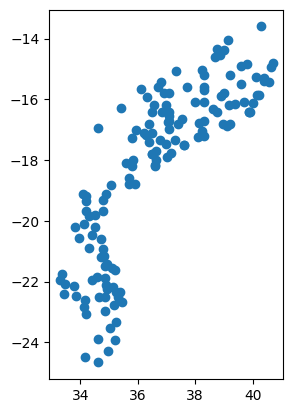

In [27]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)
cyclone_tracks_sel.plot()

In [28]:
df = df[df["name"].isin(all_storms)]

In [29]:
df.columns

Index(['valid_time', 'lt_hour', 'latitude', 'longitude', 'max_wind_kt',
       'season', 'name', 'numberseason', 'issue_time', 'MZ03_distance_km',
       'MZ07_distance_km', 'MZ09_distance_km', 'MZ11_distance_km'],
      dtype='object')

In [30]:
df["issue_time"].unique()

<DatetimeArray>
['2021-07-29 06:00:00+00:00', '2022-01-21 06:00:00+00:00',
 '2022-01-21 12:00:00+00:00', '2022-01-22 00:00:00+00:00',
 '2022-01-22 06:00:00+00:00', '2022-01-22 12:00:00+00:00',
 '2022-01-22 18:00:00+00:00', '2022-01-23 00:00:00+00:00',
 '2022-01-23 06:00:00+00:00', '2022-01-23 12:00:00+00:00',
 ...
 '2019-04-23 18:00:00+00:00', '2019-04-24 00:00:00+00:00',
 '2019-04-24 06:00:00+00:00', '2019-04-24 12:00:00+00:00',
 '2019-04-24 18:00:00+00:00', '2019-04-25 00:00:00+00:00',
 '2019-04-25 06:00:00+00:00', '2019-04-25 12:00:00+00:00',
 '2019-04-25 18:00:00+00:00', '2019-04-26 00:00:00+00:00']
Length: 484, dtype: datetime64[ns, UTC]

In [31]:
df_6hr = df[df["lt_hour"] % 6 == 0]

## Comparing against IBTrACS

C:\Users\pauni\Desktop\Work\OCHA\GitHub\ds-aa-moz-cyclones\src\datasources\helpers.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["valid_time"] = pd.to_datetime(df["valid_time"], utc=True)


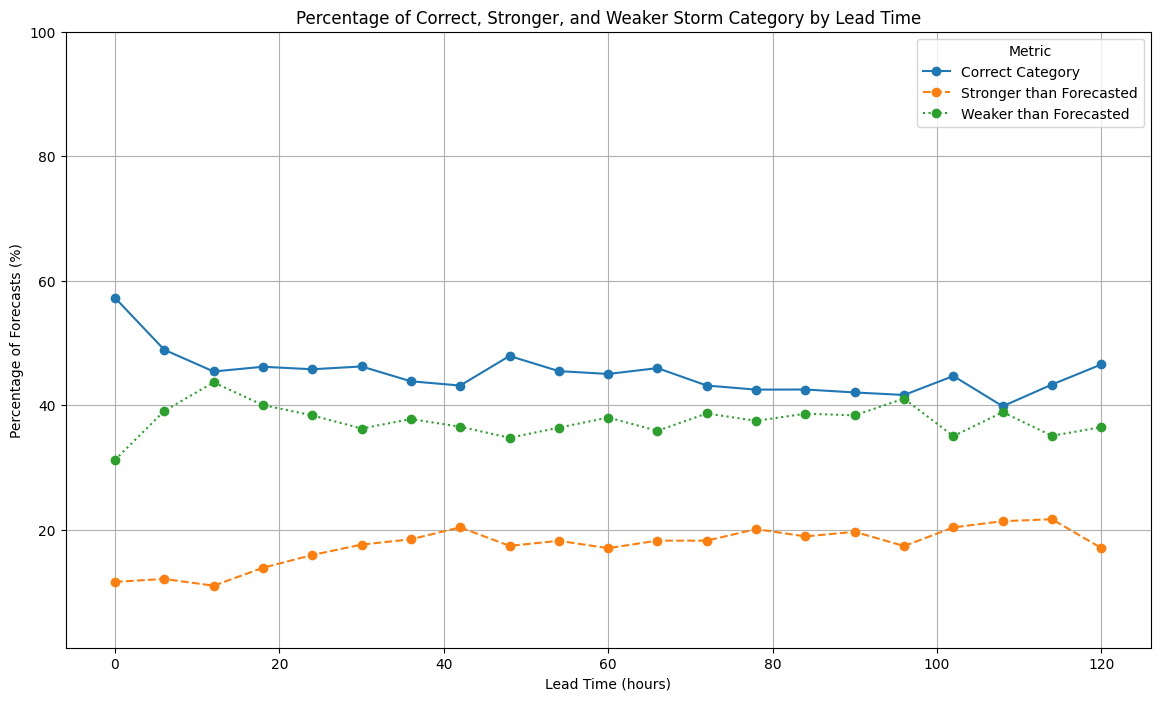

In [32]:
combined_metrics = helpers.calculate_metrics_by_category_mflr_ibtracs(
    gdf_points,
    df_6hr,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)

# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot stronger than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle="--",
    label="Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.ylim(1, 100)
plt.grid(True)
plt.show()

In [ ]:
def calculate_metrics_by_category(
    gdf_points,
    df,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
):
    # Initialize lists to store metrics
    all_metrics = []

    # Convert the forecast DataFrame valid_time to datetime
    df["valid_time"] = pd.to_datetime(df["valid_time"], utc=True)

    # Convert the gdf_points ISO_TIME to datetime and set to UTC
    gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"], utc=True)

    # Merge the gdf_points with the forecast data
    df_merged = pd.merge(
        gdf_points,
        df,
        left_on="ISO_TIME",
        right_on="valid_time",
        how="inner",
    )

    if df_merged.empty:
        raise ValueError("After merging, no data found.")

    # Convert wind speed from knots to the cyclone category
    df_merged["actual_storm_category"] = df_merged["REU_USA_WIND"].apply(
        categorize_cyclone
    )
    df_merged["forecasted_storm_category"] = df_merged["max_wind_kt"].apply(
        categorize_cyclone
    )

    # Apply category order for comparison
    df_merged["actual_category_rank"] = df_merged["actual_storm_category"].map(
        category_order
    )
    df_merged["forecasted_category_rank"] = df_merged[
        "forecasted_storm_category"
    ].map(category_order)

    # Filter by actual storm category if specified
    if storm_category_filters:
        df_merged = df_merged[
            df_merged["actual_storm_category"].isin(storm_category_filters)
        ]

    # Apply longitude cutoff
    if longitude_cutoffs:
        df_merged = df_merged[df_merged["LON"] < max(longitude_cutoffs)]

    # Apply buffer around GeoDataFrame
    if buffer_kms:
        # Ensure gdf_points has a geometry column
        if "geometry" in gdf_points.columns:
            buffered_gdf = gdf_points.copy()
            buffered_gdf = gpd.GeoDataFrame(buffered_gdf, geometry="geometry")
            buffered_gdf["geometry"] = buffered_gdf.buffer(buffer_kms / 111)
            df_merged = df_merged[
                df_merged.apply(
                    lambda row: any(
                        buffered_gdf.contains(
                            gpd.GeoSeries(
                                gpd.points_from_xy([row["LON"]], [row["LAT"]])
                            )
                        )
                    ),
                    axis=1,
                )
            ]
        else:
            raise ValueError("The 'geometry' column is missing in gdf_points.")

    # Add columns to indicate the metrics
    df_merged["correct_category"] = (
        df_merged["actual_category_rank"]
        == df_merged["forecasted_category_rank"]
    )
    df_merged["stronger_than_forecasted"] = (
        df_merged["actual_category_rank"]
        > df_merged["forecasted_category_rank"]
    )
    df_merged["weaker_than_forecasted"] = (
        df_merged["actual_category_rank"]
        < df_merged["forecasted_category_rank"]
    )

    # Group by 'lt_hour' and calculate the count of each metric
    metrics_by_lead_time_category = (
        df_merged.groupby(["lt_hour"])
        .agg(
            {
                "correct_category": "sum",
                "stronger_than_forecasted": "sum",
                "weaker_than_forecasted": "sum",
            }
        )
        .reset_index()
    )

    # Append metrics to the list
    all_metrics.append(metrics_by_lead_time_category)

    if not all_metrics:
        raise ValueError("No metrics were collected. Please check the data.")

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    return combined_metrics


# Example usage
combined_metrics = calculate_metrics_by_category(
    gdf_points,
    df_6hr,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)

# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

# Combine "correct_category" and "stronger_than_forecasted"
combined_metrics["correct_or_stronger"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
)

combined_metrics["percent_correct_or_stronger"] = (
    combined_metrics["correct_or_stronger"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct or stronger category
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_correct_or_stronger"],
    marker="o",
    label="Correct or Stronger than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.ylim(0, 100)
plt.title("Percentage of Correct or Stronger Storm Category by Lead Time")
plt.grid(True)
plt.show()

## Comparing against Best Track Data

In [33]:
combined_metrics = helpers.calculate_metrics_by_category_mflr_btdata(
    cyclone_tracks_sel,
    df,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)
# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot stronger than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle="--",
    label="Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

### Combining the Correct or Stronger Categories

In [34]:
# Call the function to compute metrics
combined_metrics = helpers.calculate_metrics_by_category_mflr_btdata(
    cyclone_tracks_sel,
    df,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)

# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

# Combine correct and stronger than forecasted categories
combined_metrics["combined_correct_and_stronger"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
)

# Calculate percentages for combined category
combined_metrics["percent_combined_correct_stronger"] = (
    combined_metrics["combined_correct_and_stronger"]
    / combined_metrics["total_cases"]
    * 100
)

combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot combined correct and stronger than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_combined_correct_stronger"],
    marker="o",
    label="Correct or Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct or Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.grid(True)
plt.show()